## Inteligencia Artificial 2022

#### Alan Reyes-Figueroa

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_species_distributions
from sklearn.neighbors import KernelDensity

In [2]:
# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False

In [3]:
def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)

## Data

In [4]:
# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']

In [5]:
Xtrain = np.vstack([data['train']['dd lat'],
                    data['train']['dd long']]).T
ytrain = np.array([d.decode('ascii').startswith('micro')
                  for d in data['train']['species']], dtype='int')
Xtrain *= np.pi / 180.  # Convert lat/long to radians

In [6]:
# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()

In [7]:
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = xy[land_mask]
xy *= np.pi / 180.

In [8]:
print(Xtrain.shape, ytrain.shape)

(1624, 2) (1624,)


In [9]:
print((ytrain==0).sum())
print((ytrain==1).sum())

926
698


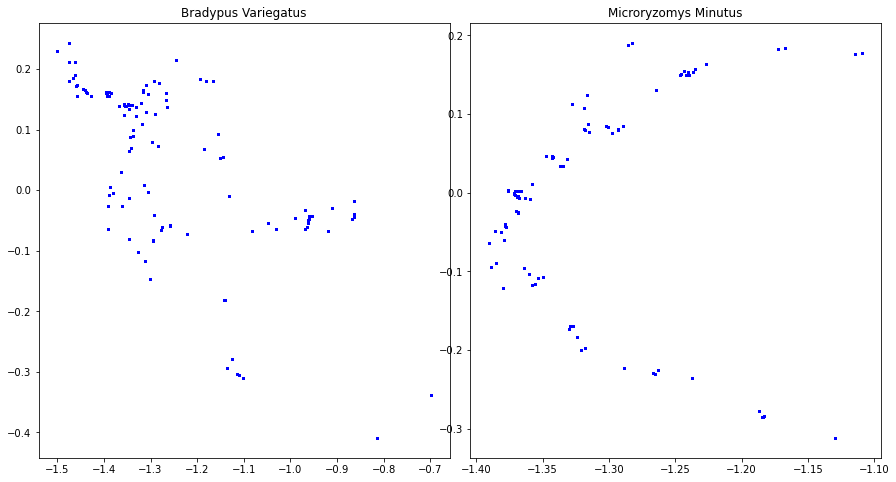

In [10]:
# Plot map of South America with distributions of each species
fig = plt.figure(figsize=(13,8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    plt.plot(Xtrain[ytrain == i,1], Xtrain[ytrain == i,0], 'bo', ms=2)

    plt.title(species_names[i])

plt.show()

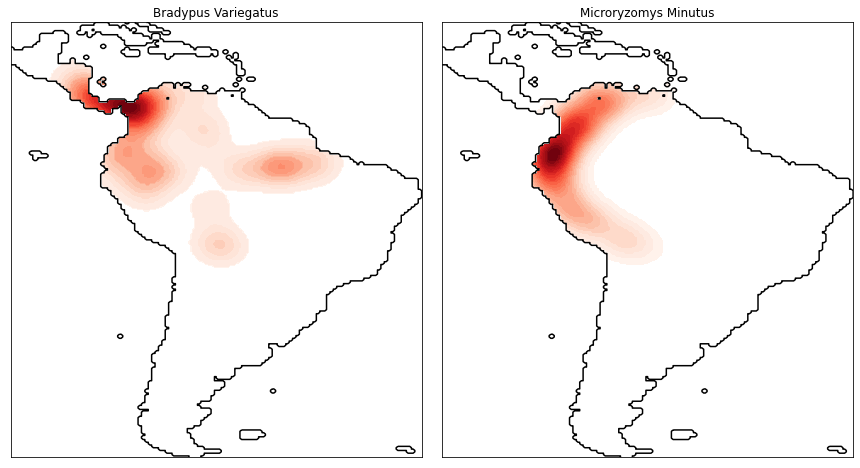

In [11]:
# Plot map of South America with distributions of each species
fig = plt.figure(figsize=(13,8))
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    #print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(bandwidth=0.04, metric='haversine',
                        kernel='gaussian', algorithm='ball_tree')
    kde.fit(Xtrain[ytrain == i])

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999, dtype='int')
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

    if basemap:
        #print(" - plot coastlines using basemap")
        m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                    urcrnrlat=Y.max(), llcrnrlon=X.min(),
                    urcrnrlon=X.max(), resolution='c')
        m.drawcoastlines()
        m.drawcountries()
    else:
        #print(" - plot coastlines from coverage")
        plt.contour(X, Y, land_reference,
                    levels=[-9998], colors="k",
                    linestyles="solid")
        plt.xticks([])
        plt.yticks([])

    plt.title(species_names[i])

plt.show()